In [2]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset, LandmarkWaveletDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

In [4]:
# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)

In [5]:
%pdb on
from simple_autoencoder import Autoencoder, PLWaveletAutoencoder
model = PLWaveletAutoencoder(landmark_files, n_neurons=[480, 512, 512, 30], lr=1e-3, patience=20)
# model.prepare_data()

Automatic pdb calling has been turned ON


In [6]:
bx = next(iter(model.train_dataloader()))

In [6]:
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=50, logger=pl.loggers.WandbLogger("wavelet landmarks autoencoder"))
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 1 M   


/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

In [7]:
K = 30
X_encoded = model.model.encode(model.all_ds)
kmeans = KMeans(K)
labels = kmeans.fit_predict(X_encoded)

In [10]:
from collections import Counter

Counter(labels).most_common(), len(set(labels)), len(labels)

([(16, 383158),
  (24, 144772),
  (11, 105625),
  (19, 69167),
  (13, 63424),
  (21, 63182),
  (1, 62698),
  (2, 62498),
  (17, 56900),
  (12, 56758),
  (23, 49450),
  (4, 45366),
  (14, 43238),
  (3, 33356),
  (27, 29705),
  (22, 24172),
  (0, 23210),
  (29, 17655),
  (10, 17461),
  (7, 10044),
  (15, 9321),
  (8, 8876),
  (5, 7747),
  (18, 7567),
  (25, 6782),
  (26, 6660),
  (20, 6643),
  (9, 5678),
  (6, 5458),
  (28, 5303)],
 30,
 1431874)

In [17]:
from collections import Counter

Counter(labels).most_common()

[(19, 474355),
 (4, 359681),
 (18, 246899),
 (9, 97409),
 (7, 92428),
 (2, 41557),
 (11, 21755),
 (29, 15682),
 (6, 14105),
 (15, 12769),
 (10, 8702),
 (1, 7868),
 (0, 6422),
 (27, 4961),
 (22, 4634),
 (25, 3618),
 (17, 3283),
 (16, 3281),
 (26, 2480),
 (5, 2123),
 (8, 1953),
 (14, 1218),
 (21, 954),
 (23, 938),
 (13, 874),
 (24, 739),
 (3, 499),
 (20, 391),
 (12, 231),
 (28, 65)]

In [11]:
def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1]*4, len(seg)*4] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = 0
    return sequence

segments = split_labels(labels)

In [12]:
clusters = set([s[0] for s in segments])
segment_lengths_by_cluster = {c: [seg[2] for seg in segments if seg[0] == c] for c in clusters}


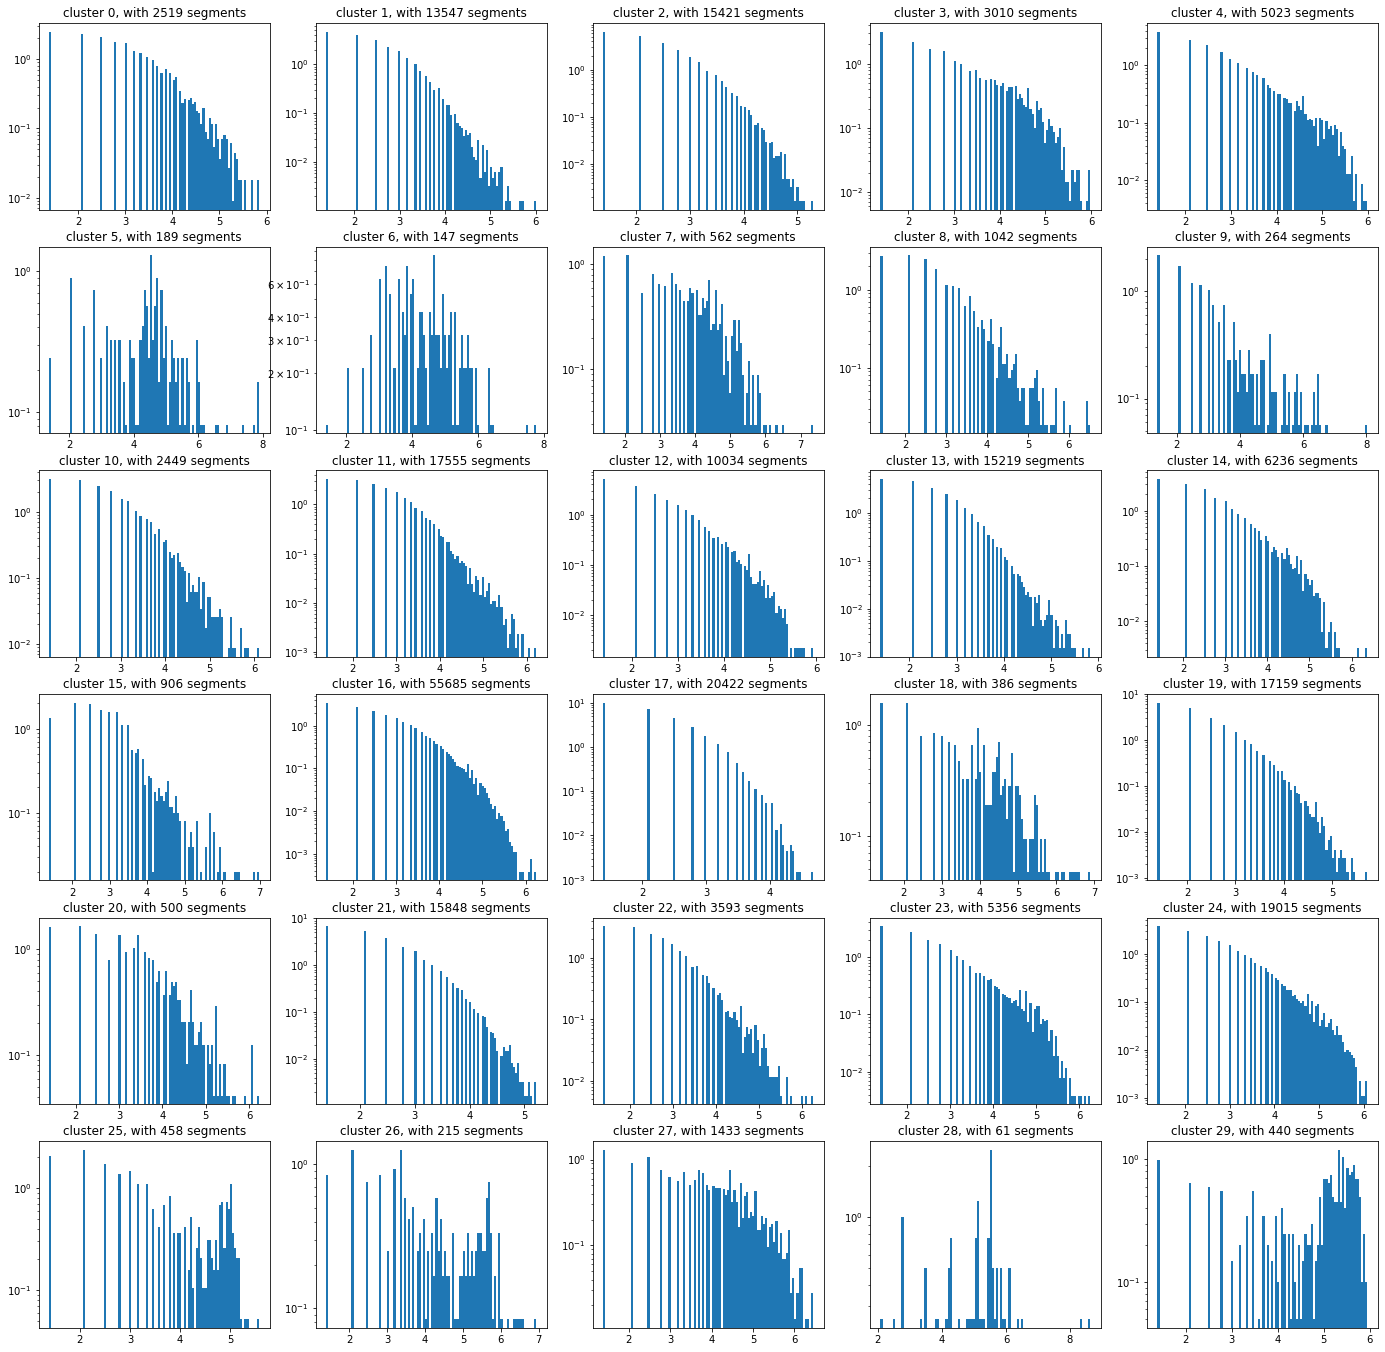

In [17]:
ncols = 5; nrows = 6
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(24, 24))
bins=np.log(np.linspace(1, 1000, 100))
for i in range(nrows):
    for j in range(ncols):
        cluster_id = i*ncols + j
        axes[i][j].set_title(f"cluster {cluster_id}, with {len(segment_lengths_by_cluster[cluster_id])} segments")
        axes[i][j].hist(np.log(segment_lengths_by_cluster[cluster_id]), bins=100, log=True, density=True)

In [11]:
def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1]*4 + model.seqlen*2, len(seg)*4] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = model.seqlen*2
    return sequence

labels_dict = dict(zip(landmark_files, 
                        np.split(labels, indices_or_sections=video_change_idxs)))

data_dict = dict(zip(landmark_files,
                    np.split(all_data, indices_or_sections=video_change_idxs)))

X_encoded_dict = dict(zip(landmark_files,
                         np.split(X_encoded, indices_or_sections=video_change_idxs)))


segment_dict = dict(zip(landmark_files, 
                        map(split_labels, np.split(labels, indices_or_sections=video_change_idxs))))


NameError: name 'video_change_idxs' is not defined